In [1]:
# 0.1 Load libraries
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# 0.2. Load the input data
counts = pd.read_csv("/Users/tgoel/Downloads/Classes/GENOME/GENOME541/hw7/allele_counts.txt", sep='\t')
counts.head()

,chr,position,refBase,refCount,NRefBase,NrefCount,depth
0,2,91822,C,42,N,2,44
1,2,202466,C,36,N,12,48
2,2,274584,C,40,N,3,43
3,2,756080,T,26,N,6,32
4,2,1052968,C,31,N,8,39


In [3]:
# get the read count and depth information
x = counts['refCount']
N = counts['depth']

In [4]:
# 0.3. Initialize model parameters and hyperparametersfor genotypes, AA, AB, BB
mu_init = [0.99, 0.5, 0.01] 
pi_init = [0.80, 0.15, 0.05] 
alpha_hyper = [10, 5, 1] 
beta_hyper = [1, 5, 10] 
delta_hyper = [8, 2, 2] 

In [5]:
# 1. Implement functions for the Binomial Mixture Model

from scipy.stats import binom
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom

# 1.1.1 Define a function to compute the observed binomial likelihood probabilities
def compute_binom_lik(x, N, mu):
    counts["AA"] = binom.pmf(x, N, mu[0])
    counts["AB"] = binom.pmf(x, N, mu[1])
    counts["BB"] = binom.pmf(x, N, mu[2])

In [6]:
# 1.1.2. Compute the binomial probabilities
compute_binom_lik(x, N, mu_init)
counts.head()

,chr,position,refBase,refCount,NRefBase,NrefCount,depth,AA,AB,BB
0,2,91822,C,42,N,2,44,6.202536e-02,5.377387e-11,9.271746e-82
1,2,202466,C,36,N,12,48,4.851809e-14,2.475124e-04,6.175313e-62
2,2,274584,C,40,N,3,43,8.255780e-03,1.403009e-09,1.197446e-76
3,2,756080,T,26,N,6,32,6.978069e-07,2.109893e-04,8.531618e-47
4,2,1052968,C,31,N,8,39,4.505405e-09,1.119110e-04,5.677071e-55


In [7]:
# 1.2. Compute the log likelihood function 'l'

# 1.2.1. Define a function, compute.loglik, that will compute the log likelihood function for the current parameter setttings
def compute_loglik(pi):
    counts["loglik"] = np.log(pi[0]*counts["AA"] + pi[1]*counts["AB"] + pi[2]*counts["BB"])

In [8]:
# 1.2.2. Compute the log likelihood for the input data
loglik = compute_loglik(pi_init)
counts.head()

,chr,position,refBase,refCount,NRefBase,NrefCount,depth,AA,AB,BB,loglik
0,2,91822,C,42,N,2,44,6.202536e-02,5.377387e-11,9.271746e-82,-3.003355
1,2,202466,C,36,N,12,48,4.851809e-14,2.475124e-04,6.175313e-62,-10.201170
2,2,274584,C,40,N,3,43,8.255780e-03,1.403009e-09,1.197446e-76,-5.019985
3,2,756080,T,26,N,6,32,6.978069e-07,2.109893e-04,8.531618e-47,-10.343338
4,2,1052968,C,31,N,8,39,4.505405e-09,1.119110e-04,5.677071e-55,-10.994712


In [9]:
# 2. Implement Functions for Genotype Inference and Parameter Estimation using EM
# 2.1 Compute the responsibilities in the E-Step

# 2.1.1 Write a function to compute the responsibilities
def compute_responsibilities(pi):
    counts["gamma_AA"] = pi[0]*counts["AA"]/(pi[0]*counts["AA"] + pi[1]*counts["AB"] + pi[2]*counts["BB"])
    counts["gamma_AB"] = pi[1]*counts["AB"]/(pi[0]*counts["AA"] + pi[1]*counts["AB"] + pi[2]*counts["BB"])
    counts["gamma_BB"] = pi[2]*counts["BB"]/(pi[0]*counts["AA"] + pi[1]*counts["AB"] + pi[2]*counts["BB"])

In [10]:
# 2.1.2 Compute gamma(Z1:T) for the first EM iteration
compute_responsibilities(pi_init)
counts.head()

,chr,position,refBase,refCount,NRefBase,NrefCount,depth,AA,AB,BB,loglik,gamma_AA,gamma_AB,gamma_BB
0,2,91822,C,42,N,2,44,6.202536e-02,5.377387e-11,9.271746e-82,-3.003355,1.000000e+00,1.625561e-10,9.342696e-82
1,2,202466,C,36,N,12,48,4.851809e-14,2.475124e-04,6.175313e-62,-10.201170,1.045455e-09,1.000000e+00,8.316505e-59
2,2,274584,C,40,N,3,43,8.255780e-03,1.403009e-09,1.197446e-76,-5.019985,1.000000e+00,3.186425e-08,9.065209e-76
3,2,756080,T,26,N,6,32,6.978069e-07,2.109893e-04,8.531618e-47,-10.343338,1.733325e-02,9.826668e-01,1.324512e-43
4,2,1052968,C,31,N,8,39,4.505405e-09,1.119110e-04,5.677071e-55,-10.994712,2.146675e-04,9.997853e-01,1.690585e-51


In [11]:
# 2.2 Updating the probability of genotypes (mixed weights) in the M-Step 

# 2.2.1 Write a function to update the parameter pi1:K
def update_pi(delta):
    pi = [counts["gamma_AA"].sum() + delta[0] - 1, counts["gamma_AB"].sum() + delta[1] - 1, counts["gamma_BB"].sum() + delta[2] - 1]
    pi /= np.sum(pi)
    return pi

In [12]:
# 2.2.2 Compute pi1:T for the first EM iteration
pi_hat = update_pi(delta_hyper)
pi_hat

array([0.79347984, 0.20200753, 0.00451263])

In [13]:
# 2.3 Updating the binomial parameter μ1:K in the M-Step 

# 2.3.1. Write a function to update the binomial parameter
def update_mu(x, N, alpha, beta):
    mu = np.array([(x*counts["gamma_AA"]).sum() + alpha[0] - 1, (x*counts["gamma_AB"]).sum() + alpha[1] - 1, (x*counts["gamma_BB"]).sum() + alpha[2] - 1])
    mu /= [(N*counts["gamma_AA"]).sum() + beta[0] + alpha[0] - 2, (N*counts["gamma_AB"]).sum() + beta[1] + alpha[1] - 2, (N*counts["gamma_BB"]).sum() + beta[2] + alpha[2] - 2]
    return mu

In [14]:
# 2.3.2 Compute the binomial parameter for the first EM iteration
mu_hat = update_mu(x, N, alpha_hyper, beta_hyper)
mu_hat

array([0.96533294, 0.64108654, 0.11949374])

In [15]:
# 2.4. Compute the log posterior 

from scipy.stats import beta
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html

from scipy.stats import dirichlet
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dirichlet.html

# 2.4.1. Define a function, compute.log.posterior, that will compute the log posterior distribution

def compute_log_posterior(mu, pi, alpha, beta_vals, delta): #use beta_vals rather than beta so it doesn't conflict with scipy.stats.beta
    counts["log_posterior"] = np.log(pi[0]*counts["AA"] + pi[1]*counts["AB"] + pi[2]*counts["BB"]) + np.log(beta.pdf(mu[0], alpha[0], beta_vals[0])) + np.log(beta.pdf(mu[1], alpha[1], beta_vals[1])) + np.log(beta.pdf(mu[2], alpha[2], beta_vals[2])) + np.log(dirichlet.pdf(pi, delta))

In [16]:
# 2.4.2. Compute the log posterior for the input data
compute_binom_lik(x, N, mu_hat)
compute_loglik(pi_hat)
compute_log_posterior(mu_hat, pi_hat, alpha_hyper, beta_hyper, delta_hyper)
counts.head()

,chr,position,refBase,refCount,NRefBase,NrefCount,depth,AA,AB,BB,loglik,gamma_AA,gamma_AB,gamma_BB,log_posterior
0,2,91822,C,42,N,2,44,2.583238e-01,9.470444e-07,1.299727e-36,-1.584868,1.000000e+00,1.625561e-10,9.342696e-82,2.483630
1,2,202466,C,36,N,12,48,5.894094e-08,3.563800e-02,9.209821e-24,-4.933787,1.045455e-09,1.000000e+00,8.316505e-59,-0.865289
2,2,274584,C,40,N,3,43,1.253679e-01,1.078912e-05,1.045571e-33,-2.307808,1.000000e+00,3.186425e-08,9.065209e-76,1.760689
3,2,756080,T,26,N,6,32,6.285320e-04,1.849234e-02,4.331004e-19,-5.464533,1.733325e-02,9.826668e-01,1.324512e-43,-1.396035
4,2,1052968,C,31,N,8,39,4.299021e-05,1.751367e-02,5.553948e-22,-5.634628,2.146675e-04,9.997853e-01,1.690585e-51,-1.566131


In [17]:
# 3. Run the Full EM algorithm

# 3.1 Implement the full EM algorithm
loss = []
while True:
    compute_responsibilities(pi_hat)

    pi_hat = update_pi(delta_hyper)
    mu_hat = update_mu(x, N, alpha_hyper, beta_hyper)

    compute_binom_lik(x, N, mu_hat)
    compute_loglik(pi_hat)
    compute_log_posterior(mu_hat, pi_hat, alpha_hyper, beta_hyper, delta_hyper)

    loss.append(np.sum(counts["log_posterior"]))
    if len(loss) > 1 and np.abs(loss[-1] - loss[-2]) < 1e-12:
        break

In [18]:
np.sum(pi_hat - [0.75145895, 0.19502661, 0.05351445])

-9.999999980858654e-09

In [19]:
np.sum(mu_hat - [0.9705156, 0.7817451, 0.2640394])

0.00010731777834305234

In [20]:
# 3.2 Determine the mutation status for the input data
counts["mutation_status"] = counts["gamma_AB"] + counts["gamma_BB"] >= 0.9
counts["mutation_status"] = counts["mutation_status"].map({True: "SNV", False: "NotSNV"})
counts.head()

,chr,position,refBase,refCount,NRefBase,NrefCount,depth,AA,AB,BB,loglik,gamma_AA,gamma_AB,gamma_BB,log_posterior,mutation_status
0,2,91822,C,42,N,2,44,2.338921e-01,0.001460,2.628508e-22,-1.737238,9.983809e-01,0.001619,7.991969e-23,1.624602,NotSNV
1,2,202466,C,36,N,12,48,1.017970e-08,0.114973,2.663072e-12,-3.796816,3.407841e-07,1.000000,6.350254e-12,-0.434976,SNV
2,2,274584,C,40,N,3,43,9.545944e-02,0.006797,3.619798e-20,-2.616685,9.818359e-01,0.018164,2.651967e-20,0.745155,NotSNV
3,2,756080,T,26,N,6,32,2.726749e-04,0.162528,1.323572e-10,-3.444228,6.415974e-03,0.993584,2.218343e-10,-0.082388,SNV
4,2,1052968,C,31,N,8,39,1.384335e-05,0.153424,6.246334e-12,-3.507960,3.471658e-04,0.999653,1.115795e-11,-0.146120,SNV


In [21]:
# save results
counts.to_csv('/Users/tgoel/Downloads/Homework7_mutationCalls_Tanush-Goel.txt', sep='\t',index=False)

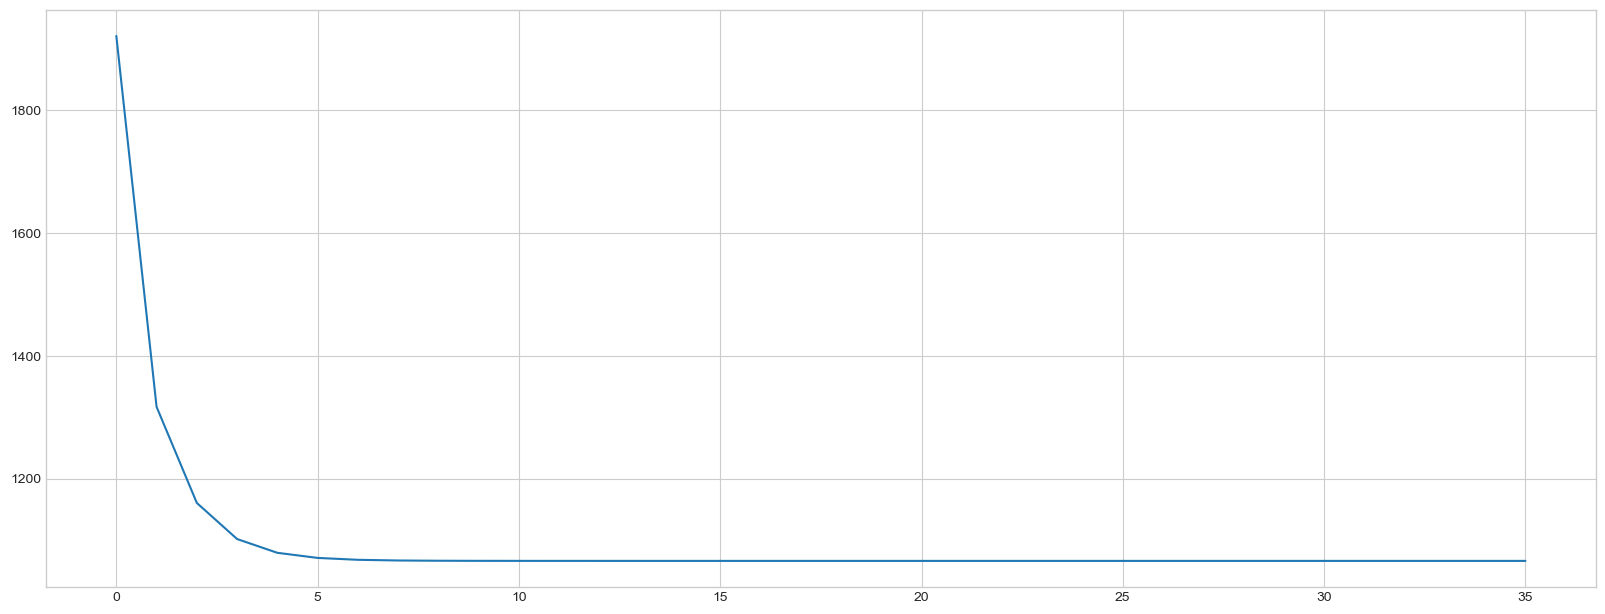

In [30]:
# 3.3. Plot the log posterior
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7.5))
plt.plot(loss)

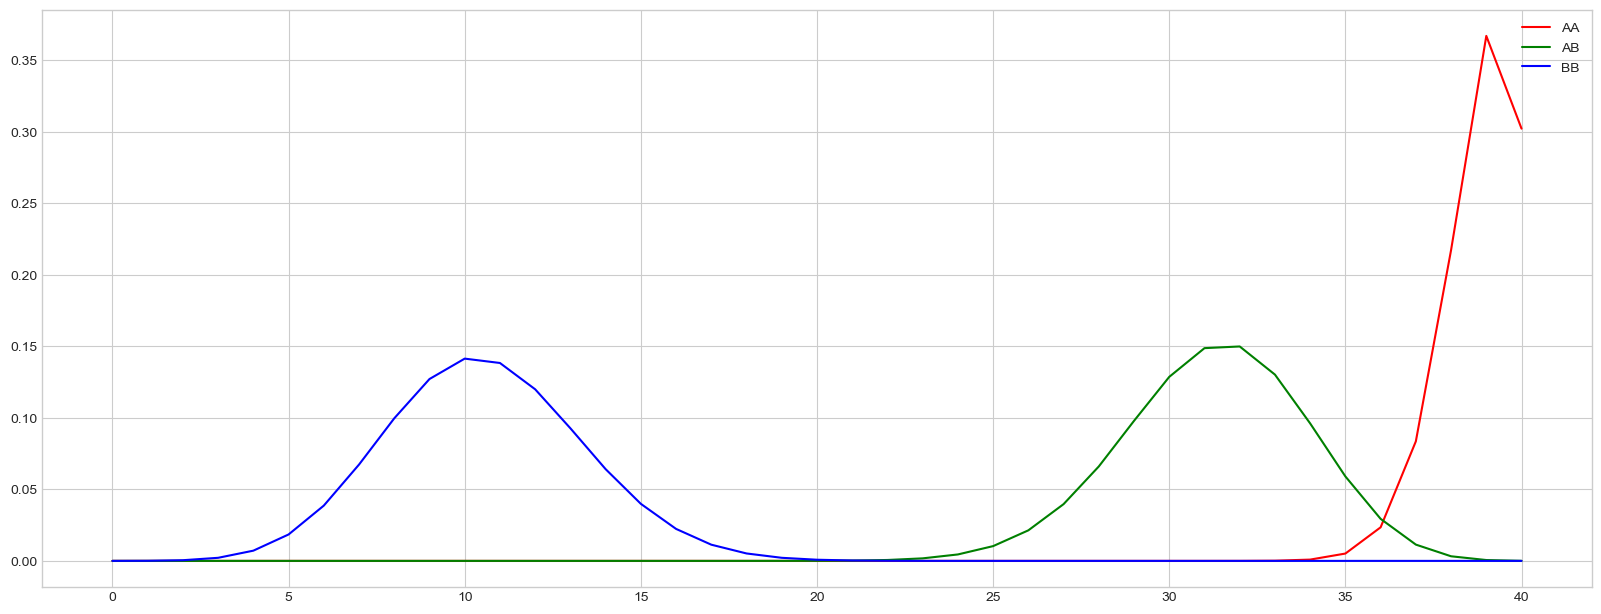

In [31]:
# 3.4. Plot the binomial pmf for the converged parameters
plt.figure(figsize=(20, 7.5))
x = np.arange(41)
plt.plot(x, binom.pmf(x, 40, mu_hat[0]), label="AA", color="red")
plt.plot(x, binom.pmf(x, 40, mu_hat[1]), label="AB", color="green")
plt.plot(x, binom.pmf(x, 40, mu_hat[2]), label="BB", color="blue")
plt.legend()
plt.show()